In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

df = pd.read_csv("SeoulBikeDataClean.csv")

# Time-based train/val/test split
train_df = df[df['datetime'] < '2018-10-01']
val_df   = df[(df['datetime'] >= '2018-10-01') & (df['datetime'] < '2018-11-01')]
test_df  = df[df['datetime'] >= '2018-11-01']

print("Train:", train_df.shape)
print("Val:  ", val_df.shape)
print("Test: ", test_df.shape)


Train: (6984, 40)
Val:   (665, 40)
Test:  (648, 40)


In [2]:
# Fit Negative Binomial model
formula_nb = 'rented_bike_count ~ humiditypct + solar_radiation_mj_m2 + Autumn + Spring + Summer + Winter +' \
' phase0to6 + phase7to9 + phase10to17 + phase18to19 + phase20to24 + is_raining + is_snowing + temperaturec_squared +' \
' is_weekend + is_holiday + is_working_day + temp_rain + temp_snow + lag_1 + lag_24 + rolling_24_mean + rolling_168_mean'

nb_model = smf.glm(
    formula=formula_nb,
    data=train_df,
    family=sm.families.NegativeBinomial()
).fit()

print(nb_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:      rented_bike_count   No. Observations:                 6984
Model:                            GLM   Df Residuals:                     6963
Model Family:        NegativeBinomial   Df Model:                           20
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -49988.
Date:                Mon, 12 May 2025   Deviance:                       1632.4
Time:                        14:50:51   Pearson chi2:                 1.38e+03
No. Iterations:                    14   Pseudo R-squ. (CS):             0.5652
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.88

c:\Users\dkkdk\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Negative Binomial Test RMSE: 320.02
Negative Binomial Test R²: 0.5063


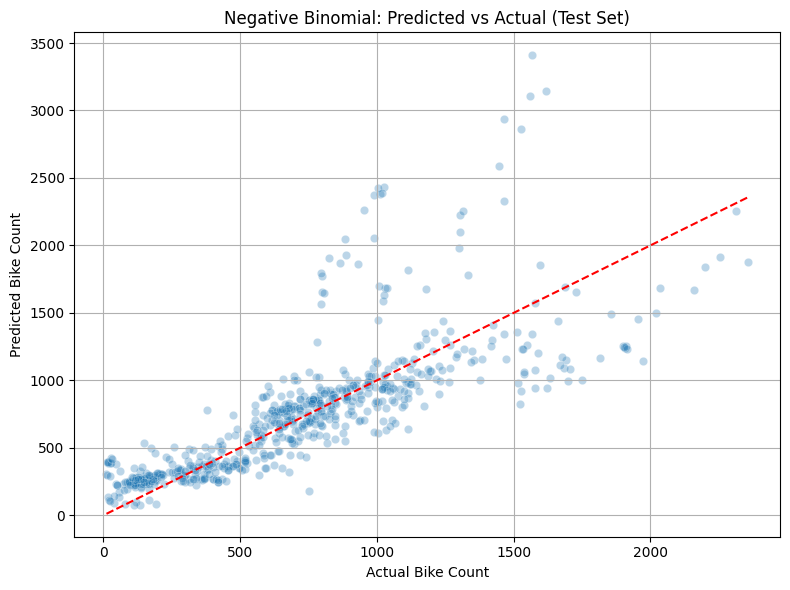

In [3]:
# Evaluate NB model on training set

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

test_X = test_df[['humiditypct',
       'solar_radiation_mj_m2', 'Autumn',
       'Spring', 'Summer', 'Winter', 'phase0to6', 'phase7to9', 'phase10to17', 'phase18to19', 'phase20to24', 'is_raining',
       'is_snowing', 'temperaturec_squared', 'is_weekend', 'is_holiday',
       'is_working_day', 'temp_rain', 'temp_snow', 'lag_1',
       'lag_24', 'rolling_24_mean', 'rolling_168_mean']]

y_true = test_df['rented_bike_count']
y_pred_nb = nb_model.predict(test_X)

rmse_nb = mean_squared_error(y_true, y_pred_nb, squared=False)
r2_nb = r2_score(y_true, y_pred_nb)

print(f"Negative Binomial Test RMSE: {rmse_nb:.2f}")
print(f"Negative Binomial Test R²: {r2_nb:.4f}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred_nb, alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual Bike Count")
plt.ylabel("Predicted Bike Count")
plt.title("Negative Binomial: Predicted vs Actual (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()
